# Image Caption Generator (InceptionV3 and COCO-2017 dataset)

## Importing Libraries

In [1]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time
import collections
import random
import numpy as np
import json


from keras import Input, layers
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import add
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg19 import VGG19
#from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

from tqdm import tqdm

## Importing Dataset and data preprocessing

In [2]:
train_images = '../input/coco-2017-dataset/coco2017/train2017/'
test_images = '../input/coco-2017-dataset/coco2017/test2017/'
glove_path = '../input/glove6b/glove.6B.200d.txt'

In [3]:
train_images_len = len(os.listdir(train_images))
test_images_len = len(os.listdir(test_images))
print(train_images_len)
print(test_images_len)

118287
40670


In [4]:
annotation_file = '../input/coco-2017-dataset/coco2017/annotations/captions_train2017.json'
with open(annotation_file, 'r') as f:
    annotations = json.load(f)
print(annotations['annotations'][0])

{'image_id': 203564, 'id': 37, 'caption': 'A bicycle replica with a clock as the front wheel.'}


In [5]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = (f"{val['caption']}")
  image_path = train_images + '%012d.jpg' % (val['image_id'])  
  image_path_to_caption[image_path].append(caption)

In [6]:
print(len(image_path_to_caption))
image_path_to_caption['../input/coco-2017-dataset/coco2017/train2017/000000519186.jpg']

118287


['Workers cleaning a large green and white boat',
 'A small barge is docked in a city port. ',
 'A green and white boat parked next to a dock full of water.',
 'A boat is docked next to a walkway on the water.',
 'A small green boat at a dock in the water.']

In [7]:
# conversion from defaultdict to dict
image_path_to_caption = dict(image_path_to_caption)
print(type(image_path_to_caption))

<class 'dict'>


## Dropping of some data from the traning set

In [8]:
import random

lst = list(image_path_to_caption.items())
#Run only one time ---
random.shuffle(lst)
x = int(len(lst)*0.5)
lst  = lst[0:x]
# ---------
image_path_to_caption = dict(lst)
print(len(image_path_to_caption))

59143


### Image_id_to_caption Function so that you can convert path_to_caption to id_to_caption whenever you want to

In [9]:
def id_caption(image_path_to_caption): 
    image_id_to_caption = collections.defaultdict(list)
    for (key,val) in image_path_to_caption.items(): 
        for values in val:
            x = key.split('/')[-1]
            x = x.split('.')[0]
            image_id_to_caption[x].append(values)

    # Convert image_id_to_caption to dict
    image_id_to_caption = dict(image_id_to_caption)
    return image_id_to_caption

In [10]:
# Clean description means remove puncutation and lowercase

#1. image_path_to_caption
table = str.maketrans('', '', string.punctuation)
for key, desc_list in image_path_to_caption.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

In [11]:
items = list(image_path_to_caption.items())
print(items[7])

('../input/coco-2017-dataset/coco2017/train2017/000000502116.jpg', ['a couple of horse mounted cops riding down the middle of a street', 'two cops on horseback on a city street with cars backed up behind them', 'two officers riding horses on a city street', 'two police officers ride down the street on horses', 'two police mounted on the backs of horses'])


In [12]:
# unique words in our caption data
vocabulary = set()
for key in image_path_to_caption.keys():
        [vocabulary.update(d.split()) for d in image_path_to_caption[key]]
print(len(vocabulary))


21660


In [13]:
# Now call the id_caption function
image_id_to_caption = id_caption(image_path_to_caption)
print(len(image_id_to_caption))
print(type(image_id_to_caption))
print(list(image_id_to_caption.keys())[:5])

59143
<class 'dict'>
['000000564020', '000000518646', '000000380842', '000000570917', '000000579053']


In [14]:
lines = list()
for key, desc_list in image_id_to_caption.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

print(type(new_descriptions))
print(new_descriptions[:400])

<class 'str'>
000000564020 a man is doing a trick on his snowboard
000000564020 a person snowboarding on a hill lined with trees
000000564020 a person snowboarding midair on a winter day
000000564020 a snowboarding mid air after coming over a snowy hill
000000564020 a snowboarder jumping a snowy slope on a mountain
000000518646 a vase filled with pink and purple flowers
000000518646 a glass vase filled with col


In [15]:
## Getting image ids
train = list(image_id_to_caption.keys())
print(train[0:5])

['000000564020', '000000518646', '000000380842', '000000570917', '000000579053']


In [16]:
train_img = list(image_path_to_caption.keys())
print(len(train_img))

59143


In [17]:
train_descriptions = dict()
for line in tqdm(new_descriptions.split('\n')):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

print(len(train_descriptions))

100%|██████████| 295876/295876 [03:41<00:00, 1336.31it/s]

59143


In [18]:
list(train_descriptions.keys())[0:5]

['000000564020',
 '000000518646',
 '000000380842',
 '000000570917',
 '000000579053']

In [19]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [20]:
print(len(all_train_captions)) # contain all the captions   5*11858 = 59173
print(all_train_captions[:5])

295876
['startseq a man is doing a trick on his snowboard endseq', 'startseq a person snowboarding on a hill lined with trees endseq', 'startseq a person snowboarding midair on a winter day endseq', 'startseq a snowboarding mid air after coming over a snowy hill endseq', 'startseq a snowboarder jumping a snowy slope on a mountain endseq']


In [21]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 5416


In [22]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [23]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 51


In [24]:
embeddings_index = {} 
f = open(glove_path, encoding="utf-8")
for line in f:   
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [25]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [26]:
embedding_matrix[5].shape

(200,)

## Model (InceptionV3)

In [27]:
# model = InceptionV3(weights='imagenet')
# model = VGG19(include_top = False, weights = 'imagenet')
model = InceptionV3(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)

2021-12-27 10:27:13.805403: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-27 10:27:13.922422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-27 10:27:13.923139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-27 10:27:13.924402: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

96124928/96112376 [==============================] - 0s 0us/step


In [28]:
from keras.preprocessing.image import load_img,img_to_array
def preprocess(image_path):
    img = load_img(image_path, target_size=(299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [29]:
# train img is array of path value to images
print(len(train_img))
print(train_img[0:5])

59143
['../input/coco-2017-dataset/coco2017/train2017/000000564020.jpg', '../input/coco-2017-dataset/coco2017/train2017/000000518646.jpg', '../input/coco-2017-dataset/coco2017/train2017/000000380842.jpg', '../input/coco-2017-dataset/coco2017/train2017/000000570917.jpg', '../input/coco-2017-dataset/coco2017/train2017/000000579053.jpg']


In [30]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    #print(fea_vec.shape)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    #print(fea_vec.shape)
    return fea_vec

In [31]:
encoding_train = {}
for img in tqdm(train_img):
    path = img.split('/')[-1]
    encoding_train[path] = encode(img)
train_features = encoding_train

# encoding_test = {}
# for img in test_img:
#     encoding_test[img[len(test_images):]] = encode(img)

  0%|          | 0/59143 [00:00<?, ?it/s]2021-12-27 10:27:24.031651: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-27 10:27:25.860835: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
100%|██████████| 59143/59143 [1:08:56<00:00, 14.30it/s]


In [32]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
      
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 51)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 51, 200)      1083400     input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [33]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [34]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [35]:
epochs = 5
batch_size = 32
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/5
1848/1848 [==============================] - 594s 320ms/step - loss: 3.3719 - accuracy: 0.3710
Epoch 2/5
1848/1848 [==============================] - 583s 316ms/step - loss: 2.7931 - accuracy: 0.4292
Epoch 3/5
1848/1848 [==============================] - 580s 314ms/step - loss: 2.6704 - accuracy: 0.4426
Epoch 4/5
1848/1848 [==============================] - 583s 315ms/step - loss: 2.6036 - accuracy: 0.4497
Epoch 5/5
1848/1848 [==============================] - 579s 314ms/step - loss: 2.5600 - accuracy: 0.4542


In [36]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [37]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

## Saving the model

In [38]:
# Saving Model to disk
model.save("image_caption_generator.h5")
print("Saved model to disk")

Saved model to disk


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Testing of the Model

In [39]:
# This function will generate caption for the image 
def generate_caption(image_path):
    image = encode(image_path)
    image = image.reshape((1, 2048))
    x=plt.imread(image_path)
    plt.imshow(x)
    plt.show()
    print("Greedy:",greedySearch(image))
    print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
    print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
    print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
    

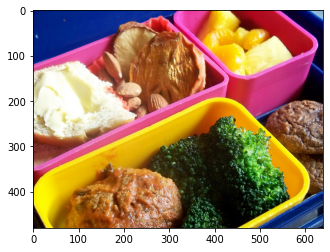

Greedy: a plate full of food and vegetables
Beam Search, K = 3: there is a plate of food on a table
Beam Search, K = 5: there is a bowl full of food on the table
Beam Search, K = 7: there is a bowl full of food on the table


In [40]:
generate_caption('../input/coco-2017-dataset/coco2017/train2017/000000000009.jpg')

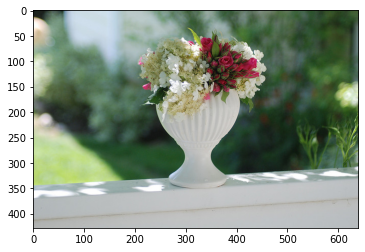

Greedy: a vase with flowers in it and a vase
Beam Search, K = 3: a white vase filled with lots of flowers in a vase
Beam Search, K = 5: a glass vase filled with lots of flowers
Beam Search, K = 7: a glass vase filled with lots of flowers


In [41]:
generate_caption('../input/coco-2017-dataset/coco2017/train2017/000000000030.jpg')

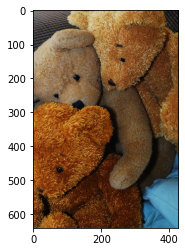

Greedy: a teddy bear is sitting on a red chair
Beam Search, K = 3: a teddy bear sitting on top of a pile of stuffed animals
Beam Search, K = 5: a large teddy bear sitting on top of a pile of stuffed animals
Beam Search, K = 7: a brown teddy bear sitting next to a bunch of stuffed animals


In [42]:
generate_caption('../input/coco-2017-dataset/coco2017/val2017/000000000776.jpg')

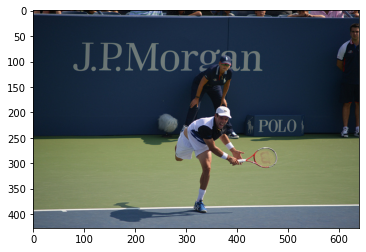

Greedy: a tennis player is getting ready to hit a ball
Beam Search, K = 3: a tennis player getting ready to hit a tennis ball
Beam Search, K = 5: a tennis player getting ready to hit a tennis ball
Beam Search, K = 7: a tennis player getting ready to hit a tennis ball


In [43]:
generate_caption('../input/coco-2017-dataset/coco2017/val2017/000000000885.jpg')

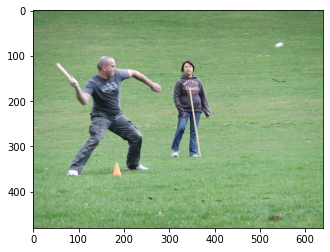

Greedy: a man is throwing a frisbee in a field
Beam Search, K = 3: a young boy flying a kite in a grassy field
Beam Search, K = 5: a group of young men playing a game of frisbee
Beam Search, K = 7: a group of young men playing a game of frisbee


In [44]:
generate_caption('../input/coco-2017-dataset/coco2017/test2017/000000000063.jpg')

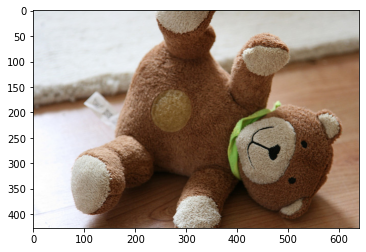

Greedy: a teddy bear is sitting on a chair
Beam Search, K = 3: a brown teddy bear sitting on top of a pile of stuffed animals
Beam Search, K = 5: a brown teddy bear sitting next to a pile of stuffed animals
Beam Search, K = 7: a brown teddy bear sitting next to a pile of stuffed animals


In [45]:
generate_caption('../input/coco-2017-dataset/coco2017/test2017/000000000155.jpg')

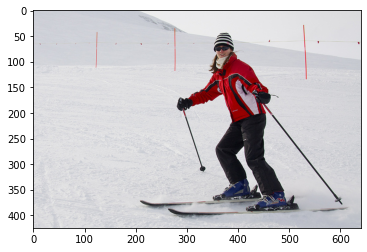

Greedy: a man riding skis down a snow covered slope
Beam Search, K = 3: a man riding skis down a snow covered slope
Beam Search, K = 5: a man riding skis down a snow covered slope
Beam Search, K = 7: a man riding skis down a snow covered slope


In [46]:
generate_caption('../input/coco-2017-dataset/coco2017/val2017/000000000785.jpg')

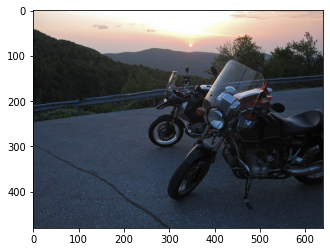

Greedy: a motorcycle parked on the side of a road
Beam Search, K = 3: a motorcycle is parked on the side of the road
Beam Search, K = 5: there is a motorcycle parked on the side of the road
Beam Search, K = 7: there is a motorcycle parked on the side of the road


In [47]:
generate_caption('../input/coco-2017-dataset/coco2017/test2017/000000000178.jpg')